This notebook is used to calculate the differential abundance of OTUs in soils with PyOM or stover additions, as compared to soil only plots

In [1]:
%load_ext rpy2.ipython
# extension for using R cell magic in python

In [2]:
%%R
# loading R packages
#library(DESeq2)
library(phyloseq)
library(plyr)
library(dplyr)
#dplyr needs to come in last
library(ggplot2)
#library(doParallel)
library(RColorBrewer)
library(gridExtra)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘dplyr’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/f

In [48]:
%%R
#detach("package:dplyr", unload=TRUE)

In [3]:
%%R
#Creating the physeq object from our tree and biom table with taxonimic and metadata already included, telling it \
# that the taxonomy is from greengenes database, so it will recognize the samples
physeq = import_biom("../data/otu_table_tax_no211_meta.biom", 
                     parseFunction=parse_taxonomy_greengenes)
# combines the otu table and the mapping file

sample.data = sample_data(physeq)

In [23]:
%%R
#run deseq on each subset of factors (day and amendment), return the factors, OTU ID, base mean, log2-fold change, 
# the standard error, and the p value associated with the response.

Dif_Abund = function(Amdmt, Day){
    physeq.pruned <- prune_samples((sample.data$Day == Day)& ((sample.data$Amdmt == Amdmt) | (sample.data$Amdmt == 0)), physeq)
    dseq = phyloseq_to_deseq2(physeq.pruned, ~Amdmt)
    dseq = DESeq(dseq, quiet = TRUE, fitType = "local")
    taxonomy = data.frame(tax_table(physeq.pruned))
    results = results(dseq)
    results$Day = Day
    results$Amdmt = Amdmt
    results = data.frame(results$Day,results$Amdmt,rownames(results),results$baseMean,results$log2FoldChange,results$lfcSE,results$pvalue,taxonomy)
    colnames(results)[1:7] = c("Day","Amdmt","OTU","baseMean","l2FC","SE","pvalue")
    results
    }

In [11]:
%%R
# Creating a matrix with the different combinations of variables for day and amendment
variables = expand.grid(Amdmt = c("1", "2"),
                        Day = c(1, 2))
variables

  Amdmt Day
1     1   1
2     2   1
3     1   2
4     2   2


In [24]:
%%R
# Joining the variables and the differential abundance
DA<-mdply(variables,Dif_Abund)
# Runs the  differential abundance function we created above on all the combinations of variables

converting counts to integer mode
converting counts to integer mode
converting counts to integer mode
converting counts to integer mode


In [25]:
%%R
head(DA)

  Day Amdmt     OTU   baseMean        l2FC         SE    pvalue  Kingdom
1   1     1  OTU.43  223.48048 -0.11012779 0.29052924 0.7046439 Bacteria
2   1     1   OTU.2 1664.01427  0.11095267 0.07837381 0.1568676 Bacteria
3   1     1 OTU.187  362.13258  0.06605159 0.15991481 0.6795756 Bacteria
4   1     1 OTU.150   39.05672  0.03205671 0.15816953 0.8393906 Bacteria
5   1     1  OTU.91   62.21140 -0.01718316 0.37497442 0.9634498 Bacteria
6   1     1 OTU.305   37.70726 -0.14629517 0.27103038 0.5893528 Bacteria
          Phylum               Class            Order            Family
1    Nitrospirae          Nitrospira    Nitrospirales    Nitrospiraceae
2 Proteobacteria Alphaproteobacteria      Rhizobiales Bradyrhizobiaceae
3  Acidobacteria      Acidobacteriia Acidobacteriales   Koribacteraceae
4 Proteobacteria Alphaproteobacteria Rhodospirillales  Acetobacteraceae
5  Bacteroidetes      Flavobacteriia Flavobacteriales   [Weeksellaceae]
6    Chloroflexi      Thermomicrobia     JG30-KF-CM45    

In order to cut down the number of samples that we even consider for significant differences, we filter out those samples that we can predict ahead of time likely won't be significant.
Then, when we adjust p values for the multiple comparisons we are making, we won't "waste" our adjustments on samples that we knew ahead of time wouldn't likely be significant.
One good predictor of whether we'll get significant results is whether the OTUs have high counts (or relative abundances). If we only have a couple of "sightings" of a given OTU, it will be unlikely we will have the statistical power to have confidence.

In [26]:
%%R
threshold = function (thresh){
    dplyr::filter(DA, baseMean >= thresh) %>% 
    dplyr::mutate(padj = p.adjust(pvalue,"BH")) %>%
    dplyr::summarize(cutoff=thresh, count=sum(padj<=0.10, na.rm = TRUE))
}
# Takes our table of differential abundance values,
# and determines those for which the baseMean values is greater or equal to whatever we input as threshould
# Then, for any samples that meet that criterion, we add a column (mutate), where we adjust the p value 
# using the Benjamini & Hochberg correction
# Then we summarize the results, listiing the cutoff threshold, and then the total number of OTUs for which the 
# new adjusted p values is less than 0.10 (just a standard level used by others).
# Note we also specify that the functions are called using dplyr package ("dplyr::").

In [27]:
%%R
range = seq(0,1,0.1)
# Creates a range of numbers we are interested in for adjusted p values

In [28]:
%%R
thresh.s <- ldply(range, threshold)
# Applys the Threshold function we created above to the range of numbers we created above.

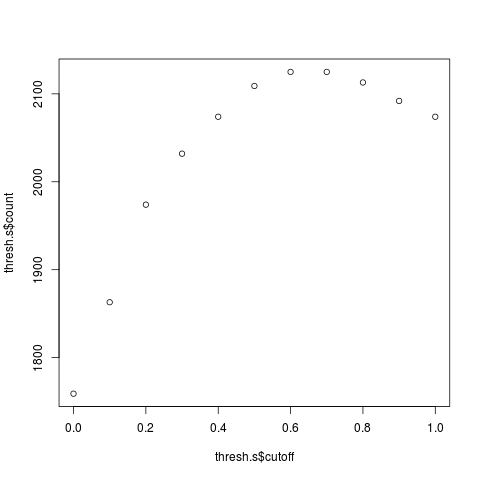

In [29]:
%%R
plot(thresh.s$count~thresh.s$cutoff)
# We can plot the threshold for base Mean value against the number of samples that will pass under this cutoff.
# We can see the optimum value to use here (here, 0.6)

In [30]:
%%R
filter(DA,baseMean>=0.6) %>% mutate(padj = p.adjust(pvalue,"BH")) %>% write.csv("../data/l2fc.csv", row.names=FALSE)
# We take that differential abundance table we created above, and filter it to include only those samples 
# that had a baseMean value above the optimal cutoff we determined above.
# We then adjust the p values and save it as a csv.

In [31]:
!head ../data/l2fc.csv | cut -c 1-80

"Day","Amdmt","OTU","baseMean","l2FC","SE","pvalue","Kingdom","Phylum","Class","
1,"1","OTU.43",223.480476760568,-0.110127792559516,0.290529241717165,0.704643875
1,"1","OTU.2",1664.01427323273,0.110952667246641,0.0783738103853471,0.1568676044
1,"1","OTU.187",362.132576964478,0.0660515941822755,0.159914812466415,0.67957556
1,"1","OTU.150",39.0567230436438,0.0320567063241244,0.158169528121542,0.83939056
1,"1","OTU.91",62.2114018390707,-0.0171831613331207,0.374974418838079,0.96344982
1,"1","OTU.305",37.7072580260407,-0.146295170832724,0.271030375040768,0.58935284
1,"1","OTU.25",187.19887275687,0.0945287904788471,0.241875397098751,0.6959332006
1,"1","OTU.4258",216.80811533347,-0.0986802477067795,0.111800295183156,0.3774267
1,"1","OTU.453",49.5655884056922,-0.172410725872039,0.1511126220515,0.2538940912


In [4]:
%%R
d = read.csv("../data/l2fc.csv")

In [5]:
%%R
max.l2fc = d %>%
            group_by(Phylum)%>%
            summarize(M = max(l2FC))
# makes a dataframe with the maximum value of log2Fold change for each phylum
POrder = max.l2fc[with(max.l2fc, order(-M)),]$Phylum
POrder

 [1] Proteobacteria   Bacteroidetes    Cyanobacteria    FBP             
 [5] Actinobacteria   Verrucomicrobia  Fibrobacteres    Spirochaetes    
 [9] Planctomycetes   Firmicutes       Chlorobi         Gemmatimonadetes
[13] Armatimonadetes  Chloroflexi      BRC1             [Thermi]        
[17] Acidobacteria    TM7              AD3              TM6             
[21] Elusimicrobia    OD1              WPS-2            OP3             
[25] <NA>             FCPU426          WS3              Nitrospirae     
[29] OP11             WS2              GAL15            BHI80-139       
31 Levels: Acidobacteria Actinobacteria AD3 Armatimonadetes ... WS3


In [6]:
%%R
d = d %>%
    mutate(pfilter = ifelse(padj<=0.1,padj,NA))
d$pfilter

    [1]            NA            NA            NA            NA            NA
    [6]            NA            NA            NA            NA            NA
   [11]            NA            NA            NA            NA            NA
   [16]            NA            NA            NA            NA  1.914492e-06
   [21]            NA            NA            NA            NA            NA
   [26]            NA            NA            NA            NA            NA
   [31]            NA            NA            NA            NA            NA
   [36]            NA            NA            NA            NA            NA
   [41]            NA            NA  5.422772e-02            NA            NA
   [46]            NA            NA            NA            NA            NA
   [51]  2.333348e-03            NA  3.141645e-02            NA            NA
   [56]            NA            NA            NA            NA            NA
   [61]            NA            NA  1.104401e-02            NA 

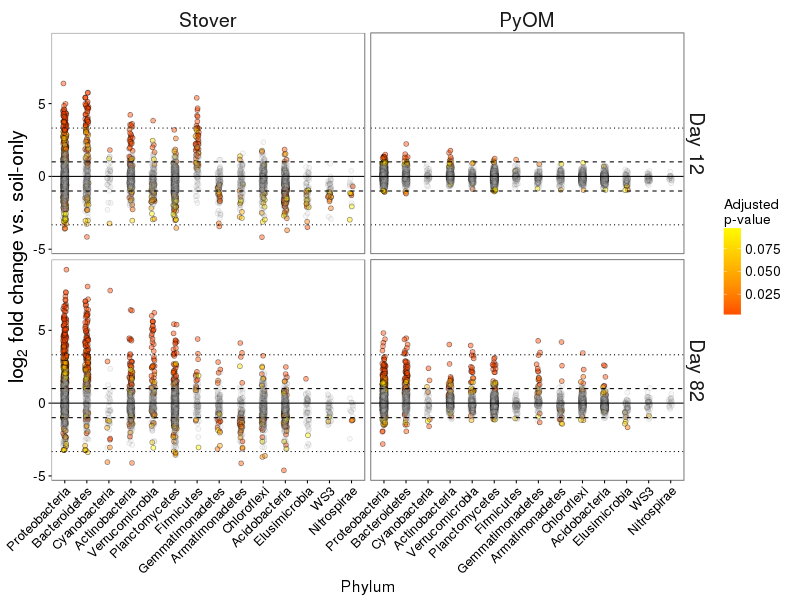

In [24]:
%%R -w 800 -h 600
# setting the image sizes, then making the figure...

d = read.csv("../data/l2fc.csv")

d = d %>%
    mutate(pfilter = ifelse(padj<=0.1,padj,NA))

d$Phylum = substr(as.character(d$Phylum),0,nchar(as.character(d$Phylum)))
# makes the Phylum column of our d table a character.

d$Phylum[is.na(d$Phylum)] <- "Unclassified"
# if there is an NA in the Rank2 column, then it gets called "unclassified"

d$Phylum = factor(d$Phylum)
# Establishes that Rank2 is a factor.

levels(d$Phylum)[levels(d$Phylum) == "[Thermi]"] <- "Thermi"
levels(d$Phylum)[levels(d$Phylum) == ""] <- "Unclassified"
levels(d$Phylum)[levels(d$Phylum) == "NA"] <- "Unclassified"
# Fixes two phylum labelling issues

N=60
Phyla = levels(d$Phylum)

NPhylum <- function (x){
    m = c()
    for (i in x){
       L <- length(d$Phylum[d$Phylum==i])
    if (L > N) m = c(m,i)
        }
        m
    }

Include<-as.factor(NPhylum(Phyla))
d<-d[d$Phylum %in% Include,]
d$Phylum<-factor(d$Phylum)

    
max.l2fc = d %>%
            group_by(Phylum)%>%
            summarize(M = max(l2FC))
# makes a dataframe with the maximum value of log2Fold change for each phylum
POrder = max.l2fc[with(max.l2fc, order(-M)),]$Phylum

d$Phylum = factor(d$Phylum,levels=POrder)
# takes our phylum column, and arranges it in order of our log2FoldChange values    


d$DayName = ifelse(d$Day==1,"Day 12","Day 82")
d$strip1 = paste(d$DayName)
d$AmdmtName = ifelse(d$Amdmt==1,"PyOM","Stover")
d$AmdmtName <- factor(d$AmdmtName, levels = c("Stover","PyOM"))
d$strip2 = paste(d$AmdmtName)
# Creates a "strip" column of d with either Day or Amendment

M = max(as.numeric(d$Phylum), na.rm = TRUE) + 1
d$x = as.numeric(d$Phylum)
d$x[is.na(d$x)] = M
d$x.jitter = d$x + runif(length(d$x), -1, 1) * 0.25

d$Palpha = ifelse(is.na(d$pfilter)==TRUE,0,1)
    
p = ggplot(d, aes(x = Phylum, y = l2FC, fill = pfilter, alpha = Palpha))
# establishing our plot is based on the data table d, with our x being the phylum, and the y being log2fold change,
# and the colour being based on our "yes" or "no" column in the d data table.

p = p + facet_grid(~DayName~AmdmtName, scales="free_x")
# saying we want it to present the data separately for our two variables (trtmt and month), in 2 columns

p = p + geom_point(shape = 21, size = 2,  position = position_jitter(w = 0.20))
# sets the points size and shape, and offsets them slightly (jitter) so they're not right on top of each other
    
p = p + geom_hline(yintercept = 1, linetype=2)
p = p + geom_hline(yintercept = -1, linetype=2)
p = p + geom_hline(yintercept = 3.3219, linetype=3)
p = p + geom_hline(yintercept = -3.3219, linetype=3)
p = p + geom_hline(yintercept = 0.0, linetype=1)
# puts in horizontal lines at reference values

p = p + theme_bw()
# sets a theme

p = p + theme(strip.text.x = element_text(size = 20),
              strip.text.y = element_text(size = 20),
              axis.text.x = element_text(size = 13, angle = 45, hjust = 1, vjust = 1),
              axis.title.x = element_text(size = 16),
              axis.text.y = element_text(size=14),
              axis.title.y = element_text(size = 20),
              legend.title = element_text(size=14),
              legend.text = element_text(size = 14),
              #legend.position = "none",
              strip.background = element_blank())
# sets a bunch of visual paramters for the legend (none) and other text
    
p = p + labs(x = "Phylum")
# sets the label for the x axis. I think they didn't get the different colours.

p = p + labs(y = expression(paste("", log[2]," fold change vs. soil-only",sep="")))
# sets the label for the y axes.

p = p + scale_fill_gradient(low = "orangered", high = "yellow", na.value = "grey", guide=guide_colourbar(title='Adjusted\np-value'))
p = p + scale_alpha_continuous(range = c(0.1, 0.45), guide = "none")
 
p = p + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank())
# Gets rid of the default gridlines

    
# Would be cool to colour this by relative abundance in soil to begin with.. what drives patterns more?
    
p

In [4]:
%%R
ggsave(filename = "4xLog2Padj.pdf", plot = p, width=8.5, height = 6.5)

In [9]:
%%R

d = read.csv("../data/l2fc.csv")

d = d %>%
    filter(padj<=0.1) %>%
    filter(Phylum=="Acidobacteria")


d$Tax = d$Class
d$SubG = ifelse ((d$Tax == "Acidobacteria-6" | d$Tax == "iii1-8"), "Subgroup 6",
                     ifelse((d$Tax == "[Chloracidobacteria]"), "Subgroup 4",
                            ifelse((d$Tax == "Acidobacteria-5"), "Subgroup 5",
                                   ifelse((d$Tax == "Solibacteres"), "Subgroup 3",""))))
d$Tax = d$SubG
levels(as.factor(d$SubG))

[1] ""           "Subgroup 3" "Subgroup 4" "Subgroup 5" "Subgroup 6"


In [15]:
%%R

d = read.csv("../data/l2fc.csv")

d = d %>%
    filter(padj<=0.1) %>%
    filter(Phylum=="Acidobacteria") %>%
    filter(Day == 2)


d$Tax = d$Class
d$SubG = ifelse ((d$Tax == "Acidobacteria-6" | d$Tax == "iii1-8"), "Subgroup 6",
                     ifelse((d$Tax == "[Chloracidobacteria]"), "Subgroup 4",
                        ifelse((d$Tax == "Acidobacteria-5"), "Subgroup 5",
                            ifelse((d$Tax == "Acidobacteriia"), "Subgroup 1",
                               ifelse((d$Tax == "Sva0725"), "Subgroup 10",
                                   ifelse((d$Tax == "Solibacteres"), "Subgroup 3",paste(d$Tax)))))))
d$SubG = as.factor(d$SubG)
#d$Tax = d$SubG

N=3
Taxes = levels(d$SubG)

NTax <- function (x){
    m = c()
    for (i in x){
       L <- length(d$SubG[d$SubG==i])
    if (L > N) m = c(m,i)
        }
        m
    }

Include<-as.factor(NTax(Taxes))
d<-d[d$SubG %in% Include,]
d$SubG<-factor(d$SubG)

    
#max.l2fc = d %>%
#            group_by(SubG)%>%
#            summarize(M = max(l2FC))
# makes a dataframe with the maximum value of log2Fold change for each phylum
PTax = c("Subgroup 1", "Subgroup 3", "Subgroup 4", "Subgroup 5", "Subgroup 6", "Subgroup 10")

d$SubG = factor(d$SubG,levels=PTax)
# takes our phylum column, and arranges it in order of our log2FoldChange values    


d$DayName = ifelse(d$Day==1,"Day 12","Day 82")
d$strip1 = paste(d$DayName)
d$AmdmtName = ifelse(d$Amdmt==1,"PyOM","Stover")
d$AmdmtName <- factor(d$AmdmtName, levels = c("Stover","PyOM"))
d$strip2 = paste(d$AmdmtName)
# Creates a "strip" column of d with either Day or Amendment

M = max(as.numeric(d$SubG), na.rm = TRUE) + 1
d$x = as.numeric(d$SubG)
d$x[is.na(d$x)] = M
d$x.jitter = d$x + runif(length(d$x), -1, 1) * 0.25


head(d)

  Day Amdmt      OTU  baseMean       l2FC         SE       pvalue  Kingdom
1   2     1 OTU.4258 256.46224 -0.3224363 0.09000992 0.0003406721 Bacteria
2   2     1 OTU.2889 192.30455 -0.4126998 0.13696672 0.0025856013 Bacteria
3   2     1   OTU.73 172.19739 -0.4966015 0.13537301 0.0002440793 Bacteria
4   2     1 OTU.4359 178.10508 -0.3908720 0.14010839 0.0052743373 Bacteria
5   2     1   OTU.35 247.76642  0.5734184 0.15621707 0.0002419329 Bacteria
6   2     1 OTU.1973  32.03539 -0.4637687 0.18572823 0.0125238915 Bacteria
         Phylum           Class          Order Family Genus Species Rank1
1 Acidobacteria Acidobacteria-6        iii1-15   <NA>  <NA>    <NA>  <NA>
2 Acidobacteria          iii1-8          DS-18   <NA>  <NA>    <NA>  <NA>
3 Acidobacteria          iii1-8          DS-18   <NA>  <NA>    <NA>  <NA>
4 Acidobacteria          iii1-8          DS-18   <NA>  <NA>    <NA>  <NA>
5 Acidobacteria    Solibacteres Solibacterales   <NA>  <NA>    <NA>  <NA>
6 Acidobacteria Acidobacteria-5

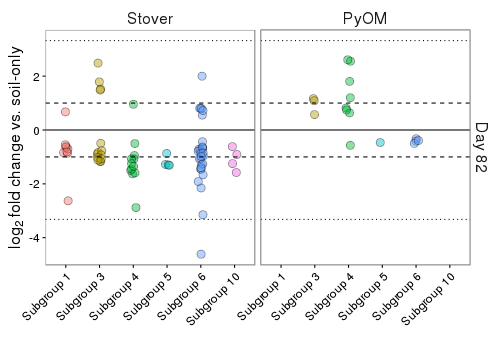

In [23]:
%%R -w 500 -h 350
# setting the image sizes, then making the figure...



p = ggplot(d, aes(x = SubG, y = l2FC, fill = SubG))
# establishing our plot is based on the data table d, with our x being the phylum, and the y being log2fold change,
# and the colour being based on our "yes" or "no" column in the d data table.

p = p + facet_grid(~DayName~AmdmtName)
# saying we want it to present the data separately for our two variables (trtmt and month), in 2 columns

p = p + geom_point(shape = 21, size = 3.5, alpha=0.45, position = position_jitter(w = 0.20))
# sets the points size and shape, and offsets them slightly (jitter) so they're not right on top of each other
    
p = p + geom_hline(yintercept = 1, linetype=2)
p = p + geom_hline(yintercept = -1, linetype=2)
p = p + geom_hline(yintercept = 3.3219, linetype=3)
p = p + geom_hline(yintercept = -3.3219, linetype=3)
p = p + geom_hline(yintercept = 0.0, linetype=1)
# puts in horizontal lines at reference values

p = p + theme_bw()
# sets a theme

p = p + theme(strip.text.x = element_text(size = 16),
              strip.text.y = element_text(size = 16),
              axis.text.x = element_text(size = 12, angle = 45, hjust = 1, vjust = 1),
              axis.title.x = element_text(size = 14),
              axis.text.y = element_text(size=12),
              axis.title.y = element_text(size = 16),
              legend.title = element_text(size=16),
              legend.text = element_text(size = 12),
              #legend.position = "none",
              strip.background = element_blank())
# sets a bunch of visual paramters for the legend (none) and other text
    
p = p + labs(x = "")
# sets the label for the x axis. I think they didn't get the different colours.

p = p + labs(y = expression(paste("", log[2]," fold change vs. soil-only",sep="")))
# sets the label for the y axes.

p = p + scale_fill_discrete(guide="none")

p = p + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank())
# Gets rid of the default gridlines

    
# Would be cool to colour this by relative abundance in soil to begin with.. what drives patterns more?
    
p

In [56]:
%%R
ggsave(filename = "AcidoLog2.pdf", plot = p, width=5, height = 5)

### Making Acido plot with signif and nonsignif responders

In [11]:
%%R -w 500 -h 350
# setting the image sizes, then making the figure...


d = read.csv("../data/l2fc.csv")

d = d %>%
    filter(padj<=1) %>%
    filter(Phylum=="Acidobacteria") %>%
    filter(Day == 2) %>%
    mutate(Signif = ifelse(padj<0.1,"yes","no"))


d$Tax = d$Class
d$SubG = ifelse ((d$Tax == "Acidobacteria-6" | d$Tax == "iii1-8"), "Subgroup 6",
                     ifelse((d$Tax == "[Chloracidobacteria]"), "Subgroup 4",
                        ifelse((d$Tax == "Acidobacteria-5"), "Subgroup 5",
                            ifelse((d$Tax == "Acidobacteriia"), "Subgroup 1",
                               ifelse((d$Tax == "Sva0725"), "Subgroup 10",
                                   ifelse((d$Tax == "Solibacteres"), "Subgroup 3",paste(d$Tax)))))))
d$SubG = as.factor(d$SubG)
d = d %>%
    mutate(Col = ifelse(Signif == "no","NotSig",paste(SubG)))

d = d[!is.na(d$SubG),]


NTax <- function (x){
    m = c()
    for (i in x){
       L <- length(d$SubG[d$SubG==i])
    if (L > N) m = c(m,i)
        }
        m
    }

Include<-as.factor(NTax(Taxes))
d<-d[d$SubG %in% Include,]
d$SubG<-factor(d$SubG)

Tax = c("Subgroup 1", "Subgroup 3", "Subgroup 4", "Subgroup 5", "Subgroup 6", "Subgroup 10")

d$SubG = factor(d$SubG,levels=PTax)
# takes our phylum column, and arranges it in order of our log2FoldChange values    


d$DayName = ifelse(d$Day==1,"Day 12","Day 82")
d$strip1 = paste(d$DayName)
d$AmdmtName = ifelse(d$Amdmt==1,"PyOM","Stover")
d$AmdmtName <- factor(d$AmdmtName, levels = c("Stover","PyOM"))
d$strip2 = paste(d$AmdmtName)
# Creates a "strip" column of d with either Day or Amendment

d = d[!is.na(d$SubG),]

head(d)

  Day Amdmt      OTU  baseMean        l2FC         SE       pvalue  Kingdom
1   2     1  OTU.187 288.42097 -0.02182216 0.15852050 0.8905080038 Bacteria
2   2     1 OTU.4258 256.46224 -0.32243634 0.09000992 0.0003406721 Bacteria
3   2     1  OTU.478  31.40626 -0.15268921 0.29440025 0.6040083316 Bacteria
4   2     1 OTU.4547 674.46807 -0.17377426 0.09457461 0.0661463815 Bacteria
5   2     1  OTU.104  80.59324 -0.01108994 0.13990705 0.9368206708 Bacteria
6   2     1  OTU.450  27.23061 -0.09428281 0.19954344 0.6365751681 Bacteria
         Phylum           Class            Order          Family Genus Species
1 Acidobacteria  Acidobacteriia Acidobacteriales Koribacteraceae  <NA>    <NA>
2 Acidobacteria Acidobacteria-6          iii1-15            <NA>  <NA>    <NA>
3 Acidobacteria         Sva0725          Sva0725            <NA>  <NA>    <NA>
4 Acidobacteria Acidobacteria-6          iii1-15            <NA>  <NA>    <NA>
5 Acidobacteria    Solibacteres   Solibacterales            <NA>  <NA>   

In [12]:
%%R
is.na(d$SubG)

  [1] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [13] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [25] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [37] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [49] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [61] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [73] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [85] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [97] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[109] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[121] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[133] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[145] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALS

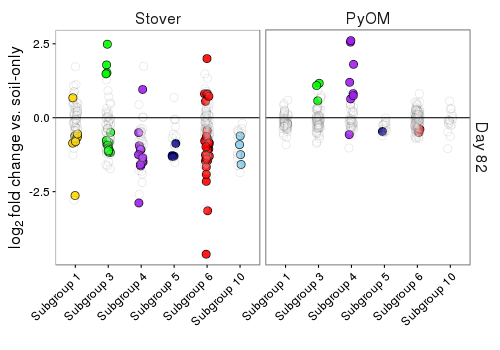

In [13]:
%%R -w 500 -h 350
# setting the image sizes, then making the figure...

p = ggplot(d, aes(x = SubG, y = l2FC, fill = Col, alpha = Col))
# establishing our plot is based on the data table d, with our x being the phylum, and the y being log2fold change,
# and the colour being based on our "yes" or "no" column in the d data table.

p = p + facet_grid(~DayName~AmdmtName)
# saying we want it to present the data separately for our two variables (trtmt and month), in 2 columns

p = p + geom_point(shape = 21, size = 3.5, position = position_jitter(w = 0.20))
# sets the points size and shape, and offsets them slightly (jitter) so they're not right on top of each other
    
#p = p + geom_hline(y = 1, linetype=2)
#p = p + geom_hline(y = -1, linetype=2)
#p = p + geom_hline(y = 3.3219, linetype=3)
#p = p + geom_hline(y = -3.3219, linetype=3)
p = p + geom_hline(yintercept = 0.0, linetype=1)
# puts in horizontal lines at reference values

p = p + theme_bw()
# sets a theme

p = p + theme(strip.text.x = element_text(size = 16),
              strip.text.y = element_text(size = 16),
              axis.text.x = element_text(size = 12, angle = 45, hjust = 1, vjust = 1),
              axis.title.x = element_text(size = 14),
              axis.text.y = element_text(size=12),
              axis.title.y = element_text(size = 16),
              legend.title = element_text(size=16),
              legend.text = element_text(size = 12),
              #legend.position = "none",
              strip.background = element_blank())
# sets a bunch of visual paramters for the legend (none) and other text
    
p = p + labs(x = "")
# sets the label for the x axis. I think they didn't get the different colours.

p = p + labs(y = expression(paste("", log[2]," fold change vs. soil-only",sep="")))
# sets the label for the y axes.

p = p + scale_fill_manual(guide="none", values=c("white","gold","skyblue","green","purple","navy","red"))
p = p + scale_alpha_manual(guide="none", values=c(0.1,0.9,0.9,0.9,0.9,0.9,0.9))


p = p + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank())
# Gets rid of the default gridlines

    
# Would be cool to colour this by relative abundance in soil to begin with.. what drives patterns more?
    
p

In [19]:
%%R
ggsave(filename = "AcidoLog2noSignif.pdf", plot = p, width=6, height = 5)

### Counting common responders for Dan

In [25]:
%%R
FDR = 0.1
cutoff = 1
d = read.csv("../data/l2fc.csv")
cr = d %>%
    mutate(sigpos = as.factor(ifelse(padj<=FDR & l2FC>=cutoff, 1,0)))
# Creates a column indicating if it's a significant positive responder.
# Now I want to know, for each day, which OTUs are common responders?
cr.Stover = cr%>%
    filter(Amdmt==2)
cr.PyOM = cr%>%
    filter(Amdmt==1)

In [26]:
%%R
cr.merge = merge(cr.PyOM, cr.Stover,
                by=c("OTU","Day","Kingdom","Phylum","Class","Order","Family","Genus","Species"),
                all=TRUE)

In [27]:
%%R
cr.merge$sigpos.x[is.na(cr.merge$sigpos.x)]=0
cr.merge$sigpos.y[is.na(cr.merge$sigpos.y)]=0

In [28]:
%%R
CR = cr.merge %>%
    mutate(Responders = ifelse(sigpos.x==1 & sigpos.y==1,"Both",
                        ifelse(sigpos.x==0 & sigpos.y==1,"Stover",
                        ifelse(sigpos.x==1 & sigpos.y==0,"PyOM","None"))))

In [29]:
%%R
print(dim(cr.merge))
print(dim(cr.PyOM))
print(dim(cr.Stover))
print(dim(CR))
print(dim(cr))

[1] 8163   25
[1] 7911   17
[1] 7321   17
[1] 8163   26
[1] 15232    17


In [30]:
%%R
ntotal = dim(otu_table(physeq))[1]
CRStover = cr.Stover %>%
    group_by(sigpos)%>%
    summarise(count=n_distinct(OTU)) %>%
    mutate(Fraction=count/ntotal)
CRPyOM = cr.PyOM %>%
    group_by(sigpos)%>%
    summarise(count=n_distinct(OTU)) %>%
    mutate(Fraction=count/ntotal)
CRTotal = cr %>%
    group_by(sigpos)%>%
    summarise(count=n_distinct(OTU)) %>%
    mutate(Fraction=count/ntotal)
print(CRStover) # Total Stover responders for both days
print(CRPyOM) # Total PyOM responders for both days
print(CRTotal) # Total responders to either amendment for both days

# A tibble: 2 x 3
  sigpos count   Fraction
  <fctr> <int>      <dbl>
1      0  3746 0.48211068
2      1   677 0.08712999
# A tibble: 2 x 3
  sigpos count   Fraction
  <fctr> <int>      <dbl>
1      0  4199 0.54041184
2      1   264 0.03397683
# A tibble: 2 x 3
  sigpos count  Fraction
  <fctr> <int>     <dbl>
1      0  4290 0.5521236
2      1   806 0.1037323


In [31]:
%%R
PyOMresp = droplevels(cr.PyOM[cr.PyOM$sigpos==1,]$OTU)
# All PyOM responding OTUs from both days
Stoverresp = droplevels(cr.Stover[cr.Stover$sigpos==1,]$OTU)
# All Stover responding OTUs from both days
Bothresp = PyOMresp[PyOMresp %in% Stoverresp]
length(Bothresp)
# Number of OTUs that respond to both amendments, but at either timepoint.
PyOMonly = PyOMresp[!(PyOMresp %in% Stoverresp)]
length(PyOMonly)
# Number of OTUs only ever respond to PyOM
Stoveronly = Stoverresp[!(Stoverresp %in% PyOMresp)]
length(Stoveronly)

[1] 628


In [32]:
%%R
head(CR)

      OTU Day  Kingdom         Phylum               Class            Order
1   OTU.1   1 Bacteria Proteobacteria Alphaproteobacteria Sphingomonadales
2   OTU.1   2 Bacteria Proteobacteria Alphaproteobacteria Sphingomonadales
3  OTU.10   1 Bacteria Actinobacteria      Actinobacteria  Actinomycetales
4  OTU.10   2 Bacteria Actinobacteria      Actinobacteria  Actinomycetales
5 OTU.100   1 Bacteria Proteobacteria Alphaproteobacteria Sphingomonadales
6 OTU.100   2 Bacteria Proteobacteria Alphaproteobacteria Sphingomonadales
              Family           Genus Species Amdmt.x baseMean.x     l2FC.x
1  Sphingomonadaceae    Kaistobacter    <NA>       1 2436.59679  0.2054216
2  Sphingomonadaceae    Kaistobacter    <NA>       1 1707.36922 -0.1233362
3 Intrasporangiaceae     Terracoccus    <NA>       1  318.85984  0.4884018
4 Intrasporangiaceae     Terracoccus    <NA>       1  331.25210  0.5907783
5  Sphingomonadaceae Novosphingobium    <NA>       1  107.69248  0.1624993
6  Sphingomonadaceae Novo

In [33]:
%%R
ntotal = dim(otu_table(physeq))[1]
CRPyOM = CR %>%
    filter(Responders=="PyOM")%>%
# Get PyOM unique responders
    arrange(-baseMean.x)
# Sort by abundance
CRPyOM[1:20,]

        OTU Day  Kingdom           Phylum                Class
1  OTU.6190   2 Bacteria   Proteobacteria   Betaproteobacteria
2    OTU.97   1 Bacteria   Proteobacteria  Alphaproteobacteria
3    OTU.78   2 Bacteria   Proteobacteria   Betaproteobacteria
4   OTU.170   2 Bacteria    Bacteroidetes        [Saprospirae]
5   OTU.635   2 Bacteria   Proteobacteria  Alphaproteobacteria
6   OTU.417   2 Bacteria              FBP                 <NA>
7   OTU.456   2 Bacteria  Verrucomicrobia     [Spartobacteria]
8  OTU.2634   2 Bacteria Gemmatimonadetes     Gemmatimonadetes
9   OTU.542   2 Bacteria Gemmatimonadetes     Gemmatimonadetes
10  OTU.527   2 Bacteria    Acidobacteria [Chloracidobacteria]
11 OTU.1960   2 Bacteria    Acidobacteria         Solibacteres
12  OTU.820   2 Bacteria    Bacteroidetes     Sphingobacteriia
13  OTU.391   2 Bacteria    Bacteroidetes        [Saprospirae]
14  OTU.873   2 Bacteria    Bacteroidetes           Cytophagia
15 OTU.1003   2 Bacteria    Bacteroidetes     Sphingoba

In [34]:
%%R
ntotal = dim(otu_table(physeq))[1]
CRBoth = CR %>%
    group_by(Day,Phylum,Responders)%>%
    summarise(count=n_distinct(OTU)) %>%
    mutate(Fraction=count/ntotal)%>%
    filter(Responders!="None")%>%
    group_by(Phylum)%>%
    arrange(Phylum)
# Note here Stover and PyOM are Stover only and PyOM only
CRBoth

Source: local data frame [60 x 5]
Groups: Phylum [21]

     Day          Phylum Responders count     Fraction
   <int>          <fctr>      <chr> <int>        <dbl>
1      1   Acidobacteria     Stover     5 0.0006435006
2      2   Acidobacteria       PyOM     6 0.0007722008
3      2   Acidobacteria     Stover     5 0.0006435006
4      1  Actinobacteria       Both     4 0.0005148005
5      1  Actinobacteria       PyOM     2 0.0002574003
6      1  Actinobacteria     Stover    25 0.0032175032
7      2  Actinobacteria       Both     9 0.0011583012
8      2  Actinobacteria       PyOM     7 0.0009009009
9      2  Actinobacteria     Stover    31 0.0039897040
10     1 Armatimonadetes     Stover     2 0.0002574003
# ... with 50 more rows


In [35]:
%%R
write.csv(CRBoth,"../data/PhylumResponse.csv", row.names=FALSE)

In [36]:
%%R
ntotal = dim(otu_table(physeq))[1]
CRBoth = CR %>%
    group_by(Day,Phylum,Responders)%>%
    summarise(count=n_distinct(OTU)) %>%
    mutate(Fraction=count/ntotal)%>%
    filter(Responders=="PyOM")
CRBoth

Source: local data frame [19 x 5]
Groups: Day, Phylum [19]

     Day           Phylum Responders count     Fraction
   <int>           <fctr>      <chr> <int>        <dbl>
1      1   Actinobacteria       PyOM     2 0.0002574003
2      1    Bacteroidetes       PyOM     4 0.0005148005
3      1       Firmicutes       PyOM     1 0.0001287001
4      1   Planctomycetes       PyOM     2 0.0002574003
5      1   Proteobacteria       PyOM     3 0.0003861004
6      2    Acidobacteria       PyOM     6 0.0007722008
7      2   Actinobacteria       PyOM     7 0.0009009009
8      2  Armatimonadetes       PyOM     1 0.0001287001
9      2    Bacteroidetes       PyOM    30 0.0038610039
10     2             BRC1       PyOM     1 0.0001287001
11     2         Chlorobi       PyOM     5 0.0006435006
12     2      Chloroflexi       PyOM     4 0.0005148005
13     2    Cyanobacteria       PyOM     3 0.0003861004
14     2              FBP       PyOM     1 0.0001287001
15     2 Gemmatimonadetes       PyOM    12 0

In [37]:
%%R
CRsummary = CR %>%
    group_by(Day,Phylum,Responders)%>%
    summarise(count=n_distinct(OTU)) %>%
    mutate(Fraction=count/sum(count))
# This should summarize the number of responders to [PyOM only, Stover only, both, or noe] in each phylum, for each day, 

In [38]:
%%R
POrder = CRsummary[CRsummary$Day==2 & CRsummary$Responders=="Stover",]
POrder$Phylum=droplevels(POrder$Phylum)
POrder = POrder %>%
    group_by(Day)%>%
    arrange(-count)

d = CR %>%
    group_by(Day,Phylum,Responders)%>%
    mutate(DayName = ifelse(Day=="1","Day 12","Day 82"))

d = d %>%
    filter(Responders != "None")

d$Phylum = factor(d$Phylum, levels = c(paste(POrder$Phylum)))

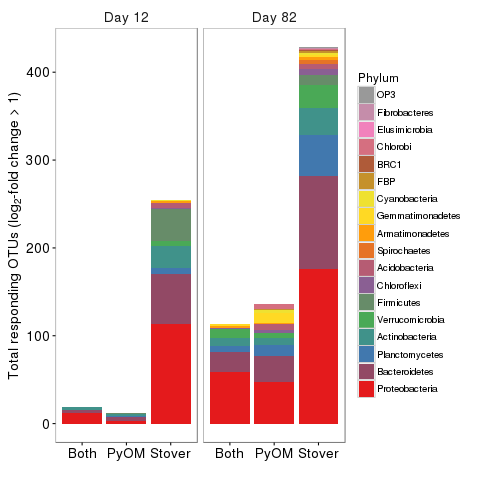

In [40]:
%%R


p = ggplot(d,aes(Responders,fill=Phylum))
p = p + geom_bar()
p = p + facet_wrap(~DayName)
p = p + guides(fill=guide_legend(reverse=TRUE))

colourCount = 18
getPalette = colorRampPalette(brewer.pal(18, "Set1"))
p = p + scale_fill_manual(values=getPalette(colourCount))

p = p + theme_bw() +
  theme(
    plot.background = element_rect(fill = "transparent", colour = NA)
   ,panel.grid.major = element_blank()
   ,panel.grid.minor = element_blank()
    ,panel.background = element_rect(fill = "transparent",colour = NA)
  ) +
  theme(strip.text.x = element_text(size=14), 
        strip.background = element_rect(colour="white", fill="white"),
       axis.text = element_text(size=14),
       axis.title.y = element_text(size=14))
p = p + labs(y=expression(paste("Total responding OTUs (", log[2],"-fold change > 1)",sep="")), x="")

p

In [9]:
%%R
ggsave(filename = "Response_Summary_1.pdf", plot = p, width=7, height = 5)

In [44]:
%%R
SummaryD1 = CRsummary%>%
    filter(Responders!="none" & Day == 1)
SummaryD1

Source: local data frame [51 x 5]
Groups: Day, Phylum [32]

     Day          Phylum Responders count    Fraction
   <int>          <fctr>      <chr> <int>       <dbl>
1      1   Acidobacteria       None   375 0.986842105
2      1   Acidobacteria     Stover     5 0.013157895
3      1  Actinobacteria       Both     4 0.010695187
4      1  Actinobacteria       None   343 0.917112299
5      1  Actinobacteria       PyOM     2 0.005347594
6      1  Actinobacteria     Stover    25 0.066844920
7      1             AD3       None    13 1.000000000
8      1 Armatimonadetes       None   111 0.982300885
9      1 Armatimonadetes     Stover     2 0.017699115
10     1   Bacteroidetes       Both     3 0.010067114
# ... with 41 more rows


In [45]:
%%R
SummaryD2 = CRsummary%>%
    filter(Responders!="none" & Day == 2)
SummaryD2[21:30,]

Source: local data frame [10 x 5]
Groups: Day, Phylum [3]

     Day        Phylum Responders count    Fraction
   <int>        <fctr>      <chr> <int>       <dbl>
1      2      Chlorobi       None     8 0.571428571
2      2      Chlorobi       PyOM     5 0.357142857
3      2      Chlorobi     Stover     1 0.071428571
4      2   Chloroflexi       Both     1 0.002881844
5      2   Chloroflexi       None   335 0.965417867
6      2   Chloroflexi       PyOM     4 0.011527378
7      2   Chloroflexi     Stover     7 0.020172911
8      2 Cyanobacteria       None    41 0.891304348
9      2 Cyanobacteria       PyOM     3 0.065217391
10     2 Cyanobacteria     Stover     2 0.043478261


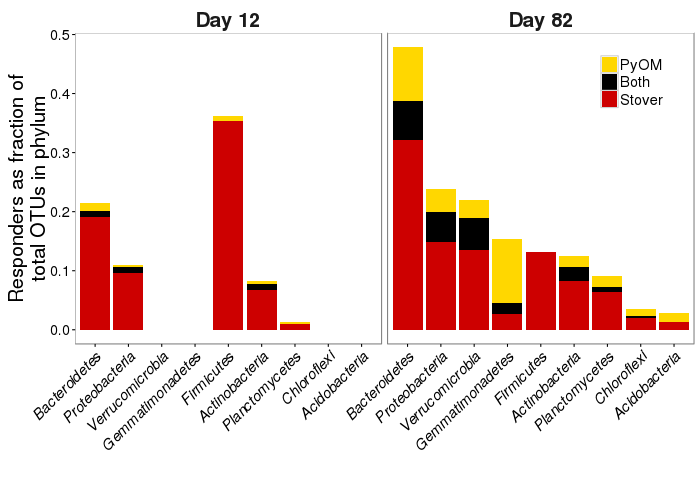

In [57]:
%%R -w 700
cutoff=7
d = CRsummary
d$Responders = factor(d$Responders, levels = c("Stover","Both","PyOM","None"))
d = d %>%
    filter(Responders!="None")%>%
    filter(sum(count)>cutoff)%>%
    arrange(Day,Responders)

POrder = CRsummary[CRsummary$Day==2,]
POrder$Phylum=droplevels(POrder$Phylum)
POrder = POrder %>%
    group_by(Day,Phylum)%>%
    filter(Responders!="None")%>%
    mutate(Total=sum(Fraction))%>%
    filter(Responders=="Stover")%>%
    group_by(Day)%>%
    arrange(-Total)
POrder$Phylum
d$Phylum = factor(d$Phylum, levels = c(paste(POrder$Phylum)))

d$Day = as.factor(d$Day)
d$Day=revalue(d$Day, c("1"="Day 12", "2"="Day 82"))

p = ggplot(d,aes(x=Phylum,y=Fraction,fill=Responders,fill=Day))
p = p + geom_bar(stat="identity")
p = p + facet_wrap(~Day)


p = p + theme_bw() +
  theme(
    plot.background = element_blank()
   ,panel.grid.major = element_blank()
   ,panel.grid.minor = element_blank()
   ,strip.text.x = element_text(size=14, face="bold")
   ,strip.background = element_rect(colour="white", fill="white"))

p = p + theme(strip.text.x = element_text(size = 20),
              strip.text.y = element_text(size = 20),
              axis.text.x = element_text(size = 15,angle=45,hjust=1,vjust=1,face="italic"),
              axis.title.x = element_text(size = 20),
              axis.text.y = element_text(size=15),
              axis.title.y = element_text(size = 20),
              legend.title = element_blank(),
              legend.text = element_text(size = 15),
             legend.position = c(0.9,0.85))

p = p + scale_fill_manual(values=c("red3","black","gold1"))

p = p + ylab("Responders as fraction of\ntotal OTUs in phylum") + xlab("")
p = p + guides(fill=guide_legend(reverse=TRUE))

p

In [58]:
%%R
ggsave(filename = "ResponsiveFraction2016.pdf", plot = p, width=9, height = 6.5)

In [15]:
%%R
write.csv(CRsummary,"../data/Response_Summary_1.csv", row.names=FALSE)

## Looking at finer level for responders - Order

In [26]:
%%R
FDR = 0.1
cutoff = 1
d = read.csv("../data/l2fc.csv")
cr = d %>%
    mutate(sigpos = ifelse(padj<FDR & l2FC>cutoff, 1,0))
# Creates a column indicating if it's a significant positive responder.
# Now I want to know, for each day, which OTUs are common responders?
cr.Stover = cr%>%
    filter(Amdmt==2)
cr.PyOM = cr%>%
    filter(Amdmt==1)
cr.merge = merge(cr.PyOM, cr.Stover, by=c("OTU","Day","Kingdom","Phylum","Class","Order","Family","Genus","Species"))
CR = cr.merge %>%
    mutate(OrdName=ifelse(Order=="NA","Unknown",c(paste(Order))))%>%
    mutate(OrdName=ifelse(is.na(Order),"Unknown",c(paste(Order))))%>%
    mutate(Responders = ifelse(sigpos.x==0 & sigpos.y==1,"Stover",ifelse(sigpos.x==1 & sigpos.y==1,"Both",ifelse(sigpos.x==1 & sigpos.y==0,"PyOM",ifelse(sigpos.x==0 & sigpos.y==0,"None","None")))))
CRsummary = CR %>%
    group_by(Day,Phylum,OrdName,Responders)%>%
    summarise(count=n_distinct(OTU)) %>%
    group_by(Day,Phylum)%>%
    mutate(Phylumtotal=sum(count))%>%
    group_by(Day,Phylum,OrdName,Responders)%>%
    mutate(Fraction=count/Phylumtotal)

In [27]:
%%R
CRsummary$OrdName = as.factor(CRsummary$OrdName)
OOrder = CRsummary[CRsummary$Responders=="Stover",]
OOrder$OrdName=droplevels(OOrder$OrdName)
OOrder = OOrder %>%
    group_by(Day)%>%
    arrange(-count)

d = CR %>%
    group_by(Day,OrdName,Responders)%>%
    mutate(DayName = ifelse(Day=="1","Day 12","Day 82"))
d = d %>%
    filter(Responders != "none")

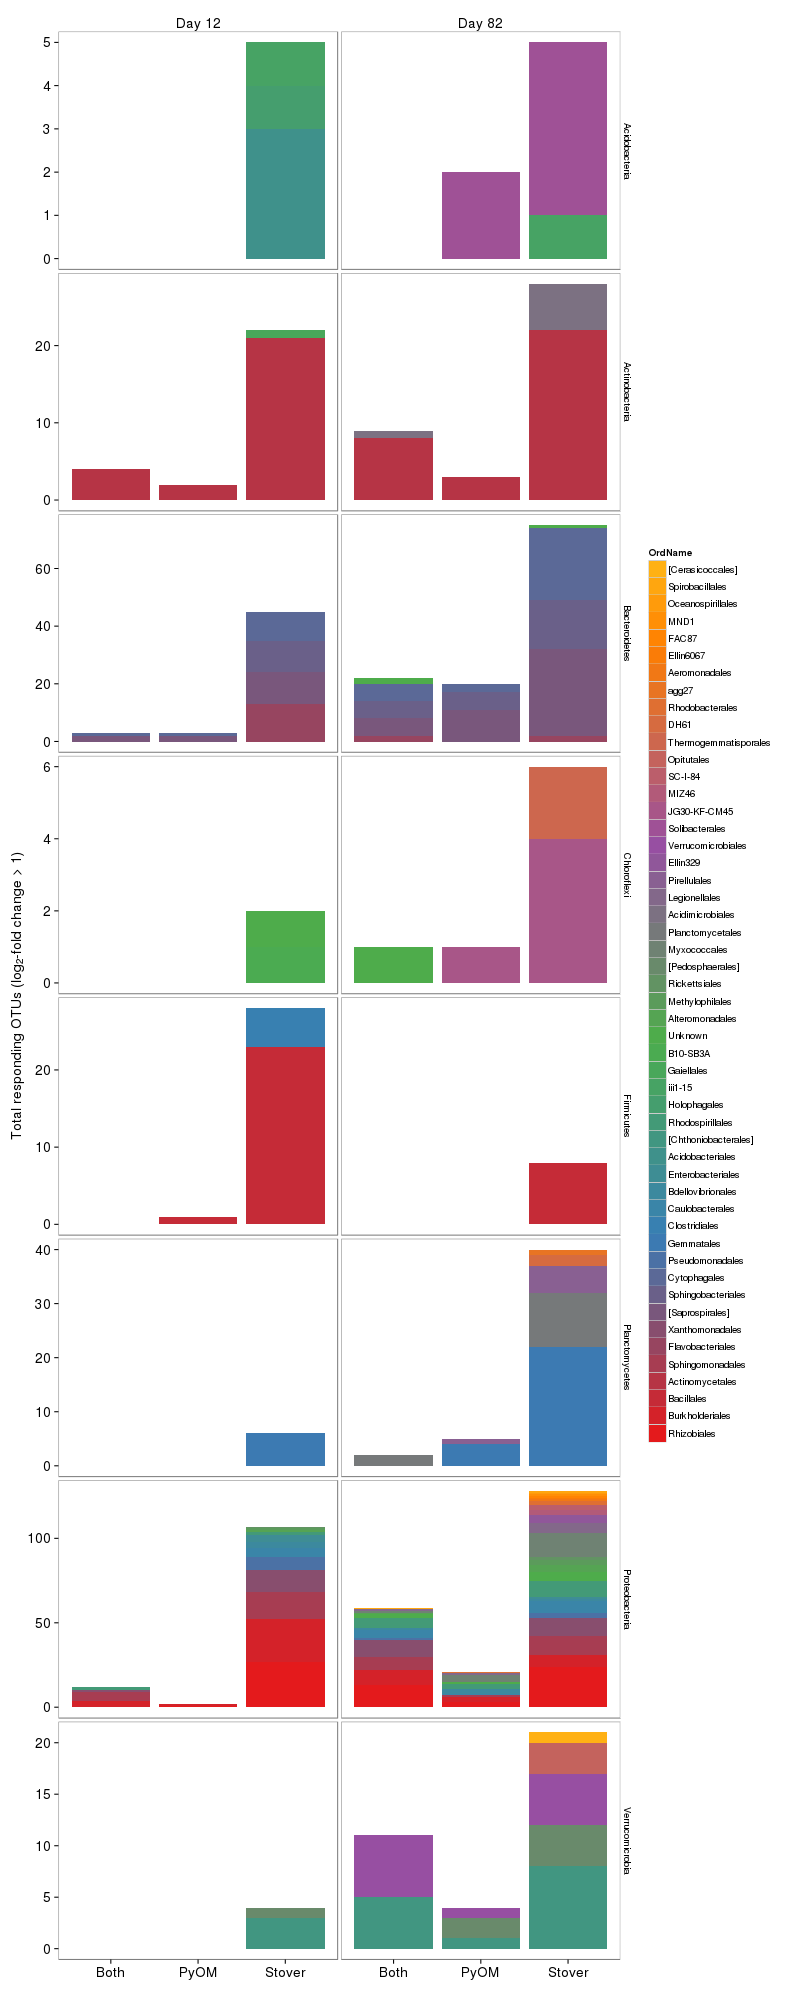

In [28]:
%%R -w 800 -h 2000

NPhyla=8

d$OrdName = factor(d$OrdName, levels = c(paste(OOrder$OrdName)))

POrder = POrder%>%
    arrange(-count)
SelectedPhyla = c(paste(POrder$Phylum[1:NPhyla]))

d = d %>%
    filter(Phylum %in% SelectedPhyla)%>%
    filter(Responders!="None")

p = ggplot(d,aes(Responders,fill=OrdName))
p = p + geom_bar()
p = p + facet_grid(~Phylum~DayName,scales="free_y")
p = p + guides(fill=guide_legend(reverse=TRUE))

colourCount = length(levels(d$OrdName))
getPalette = colorRampPalette(brewer.pal(10, "Set1"))
p = p + scale_fill_manual(values=getPalette(colourCount))

p = p + theme_bw() +
  theme(
    plot.background = element_rect(fill = "transparent", colour = NA)
   ,panel.grid.major = element_blank()
   ,panel.grid.minor = element_blank()
    ,panel.background = element_rect(fill = "transparent",colour = NA)
  ) +
  theme(strip.text.x = element_text(size=14), 
        strip.background = element_rect(colour="white", fill="white"),
       axis.text = element_text(size=14),
       axis.title.y = element_text(size=14))
p = p + labs(y=expression(paste("Total responding OTUs (", log[2],"-fold change > 1)",sep="")), x="")

p

In [96]:
%%R -w 400 -h 2000


NPhyla=11
POrder = POrder%>%
    arrange(-count)
SelectedPhyla = c(paste(POrder$Phylum[1:NPhyla]))

d = CR %>%
    group_by(Day,OrdName,Responders)%>%
    mutate(DayName = ifelse(Day=="1","Day 12","Day 82"))%>%
    filter(Responders!="None")

d = d %>%
    filter(Phylum %in% SelectedPhyla)%>%
    select(OTU,Day,Phylum,OrdName,Responders,DayName)
d$OrdName=as.factor(d$OrdName)

plots = c()

Plotter=function(phy){
    d.plot = d %>%
        filter(Phylum==phy)
   
OOrder = d.plot %>%
    group_by(Day,OrdName,Responders)%>%
    summarise(count=n_distinct(OTU)) %>%
    group_by()%>%
    arrange(Responders,-count,Day)
    
d.plot$OrdName = factor(d.plot$OrdName, levels = c(paste(OOrder$OrdName)))

    p = ggplot(d.plot,aes(Responders,fill=OrdName))
    p = p + geom_bar()
    p = p + facet_grid(~Phylum~DayName,scales="free_y")

OList = d.plot %>%
    group_by(Day,OrdName,Responders)%>%
    summarise(count=n_distinct(OTU)) %>%
    group_by()%>%
    arrange(-count)
    
    OrdersToList = c(paste(levels(OList$OrdName)))[1:45]
    colourCount = length(levels(droplevels(d.plot$OrdName)))
    getPalette = colorRampPalette(brewer.pal(10, "Set1"))
    p = p + scale_fill_manual(breaks=OrdersToList,values=getPalette(colourCount))

    p = p + theme_bw() +
      theme(
        plot.background = element_rect(fill = "transparent", colour = NA)
       ,panel.grid.major = element_blank()
       ,panel.grid.minor = element_blank()
        ,panel.background = element_rect(fill = "transparent",colour = NA)
      ) +
      theme(strip.text = element_text(size=14), 
            strip.background = element_rect(colour="white", fill="white"),
           axis.text = element_text(size=14),
           axis.title.y = element_text(size=14),
           legend.text = element_text(size=14),
           legend.position="right")
    p = p + labs(y="Total Responding OTUs", x="")

    p = p + guides(fill=guide_legend(ncol=2,title="Order",reverse=TRUE))
    p
}

for(phy in SelectedPhyla){
    thisplot = Plotter(phy)
    nam <- paste(phy, "plot.pdf", sep = ".")
    print(nam)
    #assign(nam, thisplot)
    ggsave(filename=nam,plot=thisplot,width=9.5,height=5)
    plots = c(plots,nam)
}
#p = grid.arrange(Proteobacteria.plot,Bacteroidetes.plot,Planctomycetes.plot,Actinobacteria.plot,
#             Verrucomicrobia.plot,Firmicutes.plot,Chloroflexi.plot,Acidobacteria.plot,
#             Gemmatimonadetes.plot, ncol=1,
#            heights = c(4,4,4,4,4,4,4,4,4))
#p = grid.arrange(Gemmatimonadetes.plot, ncol=1)
p

[1] "Proteobacteria.plot.pdf"
[1] "Bacteroidetes.plot.pdf"
[1] "Planctomycetes.plot.pdf"
[1] "Actinobacteria.plot.pdf"
[1] "Verrucomicrobia.plot.pdf"
[1] "Firmicutes.plot.pdf"
[1] "Chloroflexi.plot.pdf"
[1] "Acidobacteria.plot.pdf"
[1] "Armatimonadetes.plot.pdf"
[1] "Gemmatimonadetes.plot.pdf"
[1] "Spirochaetes.plot.pdf"
TableGrob (9 x 1) "arrange": 9 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (2-2,1-1) arrange gtable[layout]
3 3 (3-3,1-1) arrange gtable[layout]
4 4 (4-4,1-1) arrange gtable[layout]
5 5 (5-5,1-1) arrange gtable[layout]
6 6 (6-6,1-1) arrange gtable[layout]
7 7 (7-7,1-1) arrange gtable[layout]
8 8 (8-8,1-1) arrange gtable[layout]
9 9 (9-9,1-1) arrange gtable[layout]


In [181]:
%%R
write.csv(CRsummary,"../data/Response_Summary_1_Order.csv", row.names=FALSE)

### Looking at finer-level for family

In [182]:
%%R
FDR = 0.1
cutoff = 1
d = read.csv("../data/l2fc.csv")
cr = d %>%
    mutate(sigpos = ifelse(padj<FDR & l2FC>cutoff, 1,0))
# Creates a column indicating if it's a significant positive responder.
# Now I want to know, for each day, which OTUs are common responders?
cr.Stover = cr%>%
    filter(Amdmt==2)
cr.PyOM = cr%>%
    filter(Amdmt==1)
cr.merge = merge(cr.PyOM, cr.Stover, by=c("OTU","Day","Kingdom","Phylum","Class","Order","Family","Genus","Species"))
CR = cr.merge %>%
    mutate(FamName=ifelse(is.na(Family),"Unknown",c(paste(Family))))%>%
    mutate(Responders = ifelse(sigpos.x==0 & sigpos.y==1,"Stover",ifelse(sigpos.x==1 & sigpos.y==1,"Both",ifelse(sigpos.x==1 & sigpos.y==0,"PyOM",ifelse(sigpos.x==0 & sigpos.y==0,"None","None")))))
CRsummary = CR %>%
    mutate(FamName=ifelse(is.na(Family),"Unknown",c(paste(Family))))%>%
    group_by(Day,Phylum,FamName,Responders)%>%
    summarise(count=n_distinct(OTU))%>%
    group_by(Day,Phylum)%>%
    mutate(Phylumtotal=sum(count))%>%
    group_by(Day,Phylum,FamName,Responders)%>%
    mutate(Fraction=count/Phylumtotal)

In [183]:
%%R
CRsummary$FamName=as.factor(CRsummary$FamName)
FOrder = CRsummary[CRsummary$Responders=="Stover",]
FOrder$FamName=droplevels(FOrder$FamName)
FOrder = FOrder %>%
    group_by(Day)%>%
    arrange(-count)
d = CR %>%
    group_by(Day,FamName,Responders)%>%
    mutate(DayName = ifelse(Day=="1","Day 12","Day 82"))
d = d %>%
    filter(Responders != "none")

d$FamName = factor(d$FamName, levels = c(paste(FOrder$FamName)))

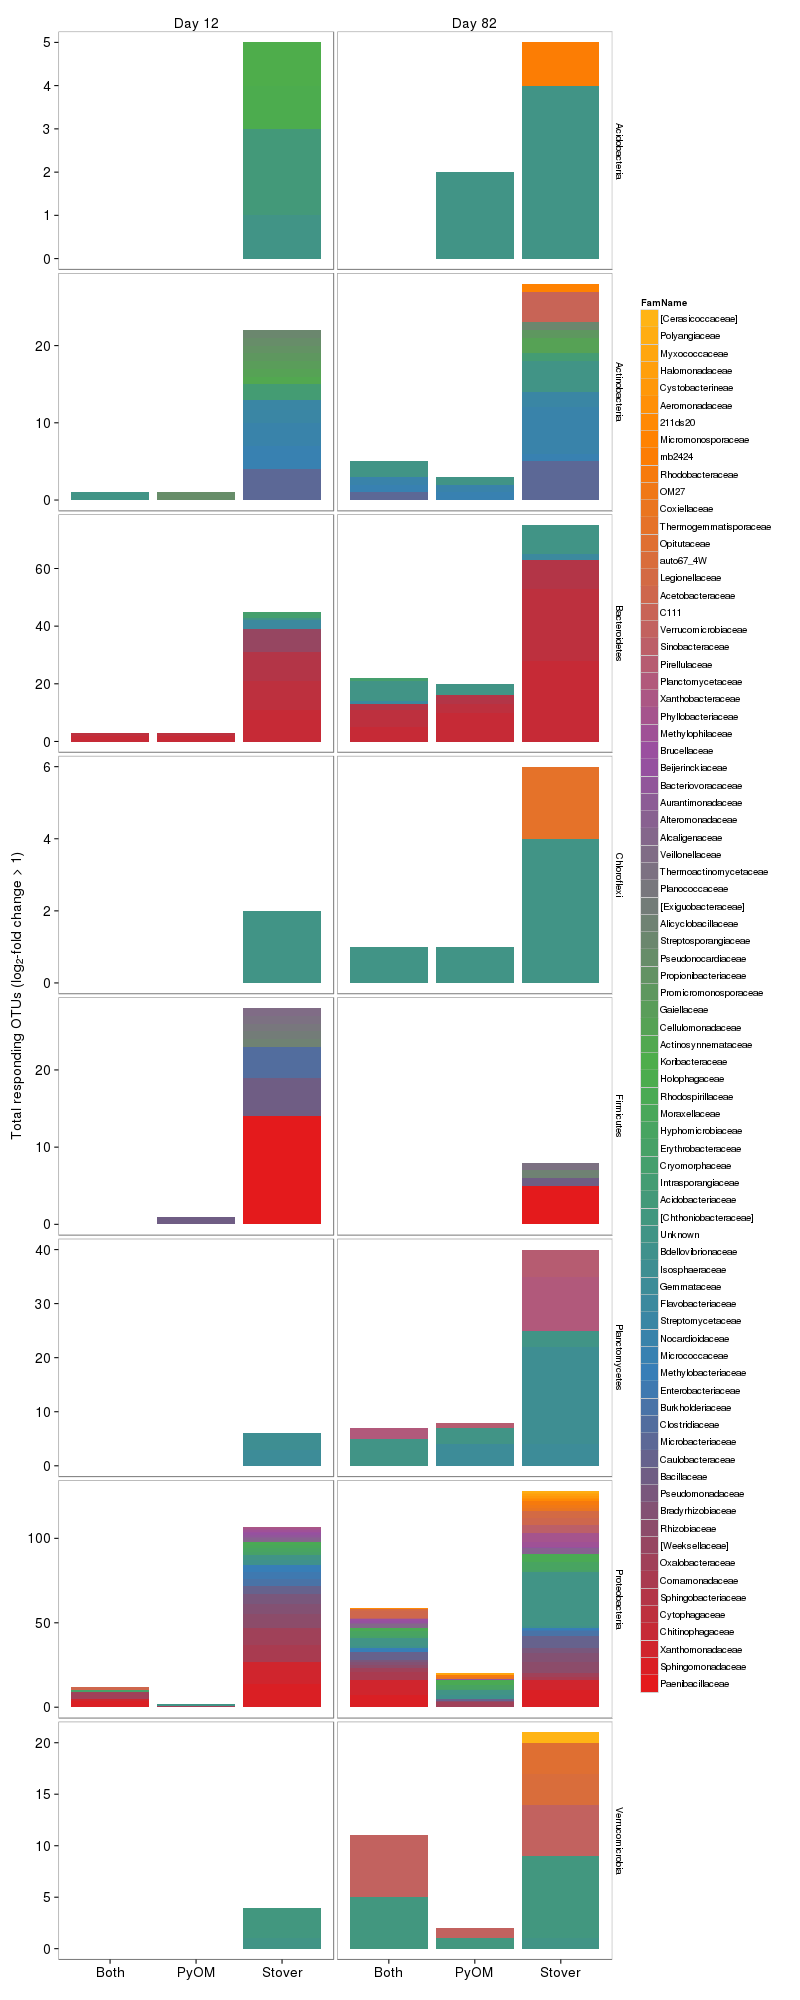

In [184]:
%%R -w 800 -h 2000

NPhyla=8

POrder = POrder%>%
    arrange(-count)
SelectedPhyla = c(paste(POrder$Phylum[1:NPhyla]))

d = d %>%
    filter(Phylum %in% SelectedPhyla)%>%
    filter(Responders!="None")

p = ggplot(d,aes(Responders,fill=FamName))
p = p + geom_bar()
p = p + facet_grid(~Phylum~DayName,scales="free_y")
p = p + guides(fill=guide_legend(reverse=TRUE))

colourCount = length(levels(d$FamName))
getPalette = colorRampPalette(brewer.pal(10, "Set1"))
p = p + scale_fill_manual(values=getPalette(colourCount))

p = p + theme_bw() +
  theme(
    plot.background = element_rect(fill = "transparent", colour = NA)
   ,panel.grid.major = element_blank()
   ,panel.grid.minor = element_blank()
    ,panel.background = element_rect(fill = "transparent",colour = NA)
  ) +
  theme(strip.text.x = element_text(size=14), 
        strip.background = element_rect(colour="white", fill="white"),
       axis.text = element_text(size=14),
       axis.title.y = element_text(size=14))
p = p + labs(y=expression(paste("Total responding OTUs (", log[2],"-fold change > 1)",sep="")), x="")

p

In [185]:
%%R
write.csv(CRsummary,"../data/Response_Summary_1_Family.csv", row.names=FALSE)